###### Assignemnt: Bayesian Convolutional Network with pyro

**Objective:** Implement, train and evaluate a Bayesian Lenet5 model on the MNIST dataset. 

**Requirements:**

- Use `torchvision.datasets.MNIST` to obtain the training and test data. Only use digits 4 and 9 (discard the others)
- Implement a bayesian neural network using `pyro` based on the Lenet5 convolutional architecture
- Use a bernoulli likelihood, a diagonal normal for the approximate posterior and a diagonal normal prior. Use the Mean Field Trace ELBO
- Evaluate the performance of the BNN using precision/recall curves and uncertainty calibration plots [2, 3, 4]
- Study the influence of the scale of the prior and the initial scale of the approximate posterior
- Compare your best bayesian model with a Deterministic Lenet5 
- Discuss your results! 


**References**
1. https://www.kaggle.com/blurredmachine/lenet-architecture-a-complete-guide
2. https://arxiv.org/pdf/1703.04977.pdf (Section 5.1)
3. https://arxiv.org/pdf/2007.06823.pdf (Section 9)
4. https://arxiv.org/pdf/1706.04599.pdf 

**Deadline**

17:30, June 16th, 2021


In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import torch

from torch.utils.data import Subset


import torch.nn as nn
import torch.nn.functional as F
import pyro
display(pyro.__version__)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

def getIdxForLabels(dataset, labels):
    mask = dataset.targets == labels[0]
    for label in labels[1:]:
        mask |= dataset.targets == label
    return np.where(mask)
def renameLabelsInOrder(dataset, labels):
    i=1
    dataset.targets[dataset.targets == 4] = 0
    for label in labels[1:]:
        dataset.targets[dataset.targets == 9] = i
        i+=1

import torchvision
mnist_train = torchvision.datasets.MNIST('./Datasets', train=True, download=True,
                                        transform=torchvision.transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST('./Datasets', train=False, download=True,
                                        transform=torchvision.transforms.ToTensor())
train_idx = getIdxForLabels(mnist_train, [4, 9])
test_idx = getIdxForLabels(mnist_test, [4, 9])

train_dataset = Subset(mnist_train, train_idx[0])
test_dataset = Subset(mnist_test, test_idx[0])

renameLabelsInOrder(mnist_train, [4, 9])
renameLabelsInOrder(mnist_test, [4, 9])


print(len(train_dataset), " elements for training.")
print(len(test_dataset), " elements for testing.")

'1.6.0'

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./Datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./Datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./Datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./Datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./Datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./Datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./Datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./Datasets/MNIST/raw

11791  elements for training.
1991  elements for testing.


/home/newt/.local/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


<IPython.core.display.Javascript object>


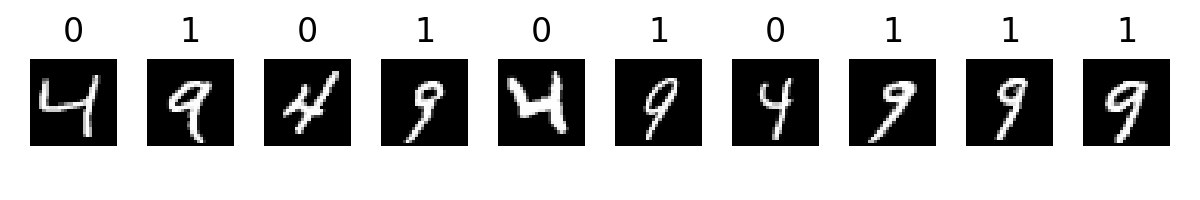

In [3]:
fig, ax = plt.subplots(1, 10, figsize=(6, 1), tight_layout=True)
for i in range(10):
    image, label = train_dataset[i]
    ax[i].imshow(image.numpy()[0, :, :], cmap=plt.cm.Greys_r)
    ax[i].axis('off')
    ax[i].set_title(label)

In [186]:
from torch.utils.data import DataLoader, SubsetRandomSampler

np.random.seed(0)
idx = list(range(len(train_dataset)))
np.random.shuffle(idx)
split = int(0.85*len(idx))

train_loader = DataLoader(train_dataset, batch_size=128, drop_last=False,
                          sampler=SubsetRandomSampler(idx[:split]))

valid_loader = DataLoader(train_dataset, batch_size=256, drop_last=False,
                          sampler=SubsetRandomSampler(idx[split:]))

test_loader = DataLoader(test_dataset, batch_size=64, drop_last=False,
                          shuffle=True)

<IPython.core.display.Javascript object>


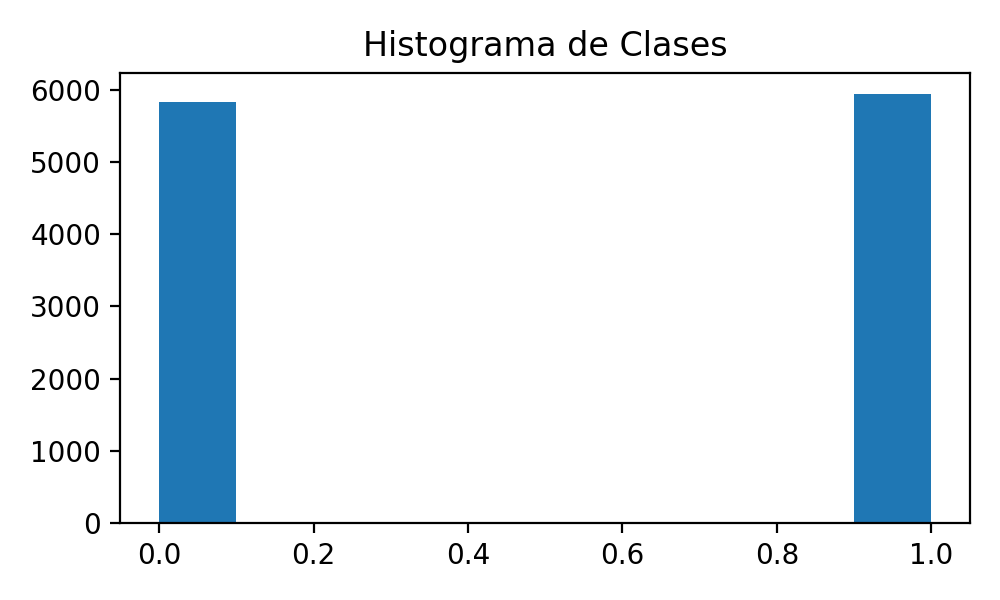

Text(0.5, 1.0, 'Histograma de Clases')

In [187]:
fig, ax = plt.subplots(figsize=(5, 3), tight_layout=True)
ax.hist(train_dataset.dataset.targets[train_dataset.indices].numpy() )
ax.set_title("Histograma de Clases")

In [188]:
class Lenet5Deterministic(nn.Module):
    def __init__(self):
        super(Lenet5Deterministic, self).__init__()
    
        self.conv1 = nn.Conv2d(1, 6, 5, stride=1)
        self.conv2 = nn.Conv2d(6, 16, 5, stride=1)
        ## Kernel size changed to 4 to fit data (original Lenet was designed for 32x32x1 imgs)
        self.conv3 = nn.Conv2d(16, 120, 4, stride=1)

        self.fc1 = nn.Linear(120, 84)  
        self.fc2 = nn.Linear(84, 1)
        
        self.activation = nn.Tanh()
        self.output = nn.Sigmoid()
        
    def forward(self, x):
        #print(x.shape)
        x = F.avg_pool2d(self.activation(self.conv1(x)), 2, stride=2)
        #print(x.shape)
        x = F.avg_pool2d(self.activation(self.conv2(x)), 2, stride=2)
        #print(x.shape)
        x = self.activation(self.conv3(x))
        #print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        #print(x.shape)
        x = self.activation(self.fc1(x))
        #print(x.shape)
                
        x = self.output(self.fc2(x))
        #x = torch.tanh(self.fc2(x))
        
        x = x.squeeze(1)

        return x

In [189]:
learning_rate = 1e-3
model = Lenet5Deterministic()

for batch, (X, y) in enumerate(train_loader):
    print(model(X))
    print(y)
    break

tensor([0.4809, 0.4819, 0.4807, 0.4817, 0.4830, 0.4805, 0.4791, 0.4783, 0.4804,
        0.4782, 0.4794, 0.4780, 0.4796, 0.4809, 0.4815, 0.4772, 0.4806, 0.4791,
        0.4783, 0.4792, 0.4778, 0.4787, 0.4819, 0.4795, 0.4772, 0.4820, 0.4811,
        0.4838, 0.4787, 0.4815, 0.4796, 0.4814, 0.4791, 0.4770, 0.4782, 0.4776,
        0.4819, 0.4797, 0.4766, 0.4828, 0.4773, 0.4794, 0.4774, 0.4816, 0.4806,
        0.4816, 0.4724, 0.4824, 0.4806, 0.4768, 0.4759, 0.4768, 0.4720, 0.4831,
        0.4768, 0.4737, 0.4810, 0.4822, 0.4758, 0.4812, 0.4792, 0.4824, 0.4811,
        0.4799, 0.4816, 0.4802, 0.4818, 0.4800, 0.4800, 0.4813, 0.4784, 0.4843,
        0.4786, 0.4798, 0.4796, 0.4834, 0.4818, 0.4802, 0.4809, 0.4797, 0.4772,
        0.4815, 0.4806, 0.4829, 0.4808, 0.4760, 0.4777, 0.4781, 0.4786, 0.4809,
        0.4818, 0.4790, 0.4768, 0.4769, 0.4796, 0.4772, 0.4793, 0.4792, 0.4816,
        0.4823, 0.4813, 0.4814, 0.4807, 0.4793, 0.4788, 0.4804, 0.4772, 0.4827,
        0.4810, 0.4807, 0.4798, 0.4825, 

In [190]:
loss = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train_loop(dataloader, model, loss_fn, optimizer, n_samples):
    size = n_samples
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        # Compute prediction and loss
        y = y.type(torch.float)
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 15 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            

def valid_loop(dataloader, model, loss_fn, n_samples):
    size = n_samples
    print(size)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            y = y.type(torch.float)
            test_loss += loss_fn(pred, y).item()
            
            correct += (torch.round(pred) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    print(f"\rValidation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    print(size)
    with torch.no_grad():
        for X, y in dataloader:
            y = y.type(torch.float)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(pred) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [191]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss, optimizer, split)
    valid_loop(valid_loader, model, loss, len(train_loader.dataset)-split)
test_loop(test_loader, model, loss)


print("Done!")

Epoch 1
-------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

loss: 0.692389  [    0/10022]
loss: 0.492592  [ 1920/10022]
loss: 0.207889  [ 3840/10022]
loss: 0.191651  [ 5760/10022]
loss: 0.208183  [ 7680/10022]
loss: 0.226819  [ 9600/10022]
1769
Validation Error: 
 Accuracy: 96.6%, Avg loss: 0.000412 

Epoch 2
-------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

loss: 0.089540  [    0/10022]
loss: 0.230267  [ 1920/10022]
loss: 0.084229  [ 3840/10022]
loss: 0.108236  [ 5760/10022]
loss: 0.084014  [ 7680/10022]
loss: 0.112614  [ 9600/10022]
1769
Validation Error: 
 Accuracy: 96.9%, Avg loss: 0.000354 

Epoch 3
-------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

loss: 0.127229  [    0/10022]
loss: 0.097562  [ 1920/10022]
loss: 0.084643  [ 3840/10022]
loss: 0.073792  [ 5760/10022]
loss: 0.084016  [ 7680/10022]
loss: 0.111734  [ 9600/10022]
1769
Validation Error: 
 Accuracy: 96.8%, Avg loss: 0.000395 

Epoch 4
-------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

loss: 0.072632  [    0/10022]
loss: 0.080083  [ 1920/10022]
loss: 0.058416  [ 3840/10022]
loss: 0.174790  [ 5760/10022]
loss: 0.078869  [ 7680/10022]
loss: 0.074179  [ 9600/10022]
1769
Validation Error: 
 Accuracy: 97.7%, Avg loss: 0.000253 

Epoch 5
-------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

loss: 0.063676  [    0/10022]
loss: 0.112868  [ 1920/10022]
loss: 0.052656  [ 3840/10022]
loss: 0.060459  [ 5760/10022]
loss: 0.105894  [ 7680/10022]
loss: 0.086553  [ 9600/10022]
1769
Validation Error: 
 Accuracy: 98.2%, Avg loss: 0.000207 

Epoch 6
-------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

loss: 0.032077  [    0/10022]
loss: 0.073795  [ 1920/10022]
loss: 0.063713  [ 3840/10022]
loss: 0.071632  [ 5760/10022]
loss: 0.063259  [ 7680/10022]
loss: 0.061829  [ 9600/10022]
1769
Validation Error: 
 Accuracy: 98.5%, Avg loss: 0.000202 

Epoch 7
-------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

loss: 0.028901  [    0/10022]
loss: 0.063418  [ 1920/10022]
loss: 0.019132  [ 3840/10022]
loss: 0.050295  [ 5760/10022]
loss: 0.031868  [ 7680/10022]
loss: 0.070181  [ 9600/10022]
1769
Validation Error: 
 Accuracy: 98.1%, Avg loss: 0.000219 

Epoch 8
-------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

loss: 0.038844  [    0/10022]
loss: 0.025189  [ 1920/10022]
loss: 0.059912  [ 3840/10022]
loss: 0.034206  [ 5760/10022]
loss: 0.021615  [ 7680/10022]
loss: 0.056229  [ 9600/10022]
1769
Validation Error: 
 Accuracy: 98.8%, Avg loss: 0.000148 

Epoch 9
-------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

loss: 0.031478  [    0/10022]
loss: 0.025628  [ 1920/10022]
loss: 0.005523  [ 3840/10022]
loss: 0.007009  [ 5760/10022]
loss: 0.058182  [ 7680/10022]
loss: 0.039365  [ 9600/10022]
1769
Validation Error: 
 Accuracy: 98.5%, Avg loss: 0.000168 

Epoch 10
-------------------------------


  0%|          | 0/79 [00:00<?, ?it/s]

loss: 0.039552  [    0/10022]
loss: 0.034716  [ 1920/10022]
loss: 0.021943  [ 3840/10022]
loss: 0.027873  [ 5760/10022]
loss: 0.060276  [ 7680/10022]
loss: 0.011137  [ 9600/10022]
1769
Validation Error: 
 Accuracy: 98.7%, Avg loss: 0.000153 

1991
Test Error: 
 Accuracy: 98.9%, Avg loss: 0.000458 

Done!


In [192]:
import pyro
from pyro.nn import PyroSample, PyroModule
import pyro.distributions as dists 
display(pyro.__version__)
pyro.set_rng_seed(12345) # Fo

'1.6.0'

In [305]:
class Lenet5Bayesian(PyroModule):
    def __init__(self, prior_scale=2., isFEBayesian=True, prior_scaleFE = 2.):
        super(Lenet5Bayesian, self).__init__()
        prior = dists.Normal(0, prior_scale)
        priorFE = dists.Normal(0, prior_scaleFE)
        
        if isFEBayesian:
            self.conv1 = PyroModule[nn.Conv2d](1, 6, 5, stride=1)
            self.conv1.weight = PyroSample(priorFE.expand([6, 1, 5, 5]).to_event(4))
            self.conv1.bias = PyroSample(priorFE.expand([6]).to_event(1))

            self.conv2 = PyroModule[nn.Conv2d](6, 16, 5, stride=1)   
            self.conv2.weight = PyroSample(priorFE.expand([16, 6, 5, 5]).to_event(4))
            self.conv2.bias = PyroSample(priorFE.expand([16]).to_event(1))

            self.conv3 = PyroModule[nn.Conv2d](16, 120, 4, stride=1)
            self.conv3.weight = PyroSample(priorFE.expand([120, 16, 4, 4]).to_event(4))
            self.conv3.bias = PyroSample(priorFE.expand([120]).to_event(1))
        else: 
            self.conv1 = nn.Conv2d(1, 6, 5, stride=1)
            self.conv2 = nn.Conv2d(6, 16, 5, stride=1)   
            ## Kernel size changed to 4 to fit data (original Lenet was designed for 32x32x1 imgs)
            self.conv3 = nn.Conv2d(16, 120, 4, stride=1)
        
        self.fc1 = PyroModule[nn.Linear](120, 84)  
        self.fc1.weight = PyroSample(prior.expand([84, 120]).to_event(2))
        self.fc1.bias = PyroSample(prior.expand([84]).to_event(1))

        
        self.fc2 = PyroModule[nn.Linear](84, 1)
        self.fc2.weight = PyroSample(prior.expand([1, 84]).to_event(2))
        self.fc2.bias = PyroSample(prior.expand([1]).to_event(1))
        
        self.output = nn.Sigmoid()
        self.activation = nn.Tanh()

        
    def forward(self, x, y=None):
        x = F.avg_pool2d(self.activation(self.conv1(x)), 2, stride=2)
        x = F.avg_pool2d(self.activation(self.conv2(x)), 2, stride=2)
        x = self.activation(self.conv3(x))
        
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension

        x = self.activation(self.fc1(x))
        x = self.output(self.fc2(x))
        #x = self.fc2(x)
        f = x.squeeze(1)

        #print(f.shape)
        with pyro.plate("data", f.shape[0]):
            loc = pyro.deterministic("k", f, event_dim=0)   
            obs = pyro.sample("obs", dists.Bernoulli(probs=loc), obs=y) #likelihood
        
        return f

In [306]:
model2 = Lenet5Bayesian(prior_scale=0.5, isFEBayesian=True, prior_scaleFE=4)
with torch.no_grad():
    for X, y in train_loader:
        pred = model2(X, y)

        print(pred.round())
        print(y)
        break

tensor([1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
        1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
        0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0.,
        0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
        0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1.,
        0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
        0., 1.])
tensor([0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
        0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 

<IPython.core.display.Javascript object>


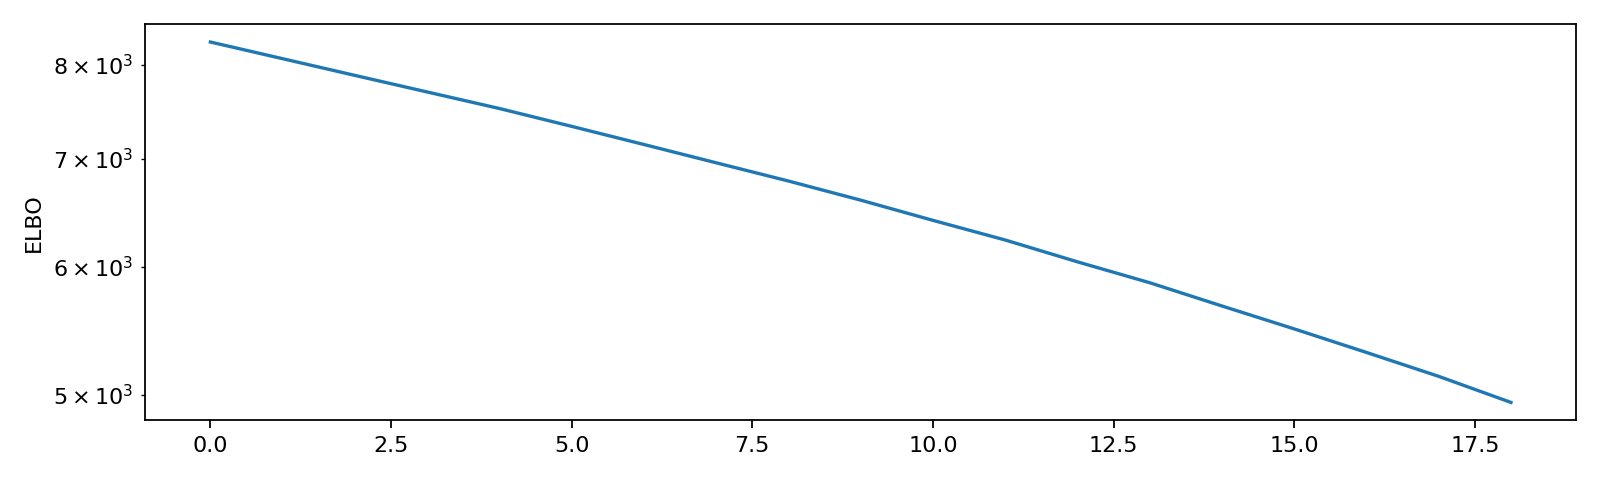

In [307]:
pyro.enable_validation(True)
fig, ax = plt.subplots(figsize=(10, 3), tight_layout=True, dpi=80)

def update_plot(k, epoch_loss):
    ax.cla()
    ax.plot(range(k), epoch_loss[:k])
    ax.set_yscale('log')
    ax.set_ylabel('ELBO')
    #ax[1].cla()
    #ax[1].plot(x, y, 'k.');
    #med = np.median(samples, axis=[0])
    #qua = np.quantile(samples, (0.05, 0.95), axis=0)
    #ax[1].plot(x_test.numpy()[:, 0], med)
    #ax[1].fill_between(x_test.numpy()[:, 0], qua[0], qua[1], alpha=0.5)
    fig.canvas.draw()
#print(pyro.poutine.trace(model2).get_trace(x_torch, y_torch).format_shapes())

In [ ]:
# Turn this on for additional debugging
pyro.enable_validation(False) 
pyro.set_rng_seed(123)
pyro.clear_param_store() 
# Create a guide
from pyro.infer.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(model2, init_scale=1e-3)
predictive = pyro.infer.Predictive(model2, guide=guide, num_samples=100)
# Create SVI object
svi = pyro.infer.SVI(model2, guide, 
                     optim=pyro.optim.ClippedAdam({'lr':2e-3}), # Optimizer
                     loss=pyro.infer.TraceMeanField_ELBO()) # Loss function 

epoch_loss = np.zeros(shape=(20,))
for k in tqdm(range(len(epoch_loss))):

    for batch, (X, y) in enumerate(train_loader):
        loss = svi.step(x=X, y=y.type(torch.float)) # Actual training step
        epoch_loss[k] = loss / len(X)

        if batch % 30 == 0:
            update_plot(k, epoch_loss)   
    res = 0
    total = 0
    for batch, (X, y) in enumerate(valid_loader):
        
        hitormiss = (predictive(X)['obs'].detach().mean(dim=0).round() == y)
        correct = np.where(hitormiss == True)[0]


        res += len(correct)
        total += X.shape[0]
    print(res/total*100)
 
            

  0%|          | 0/20 [00:00<?, ?it/s]

92.53815715093273
94.06444318824194
95.76031656302996
96.6647823629169
96.89089881288864
97.11701526286038
97.73883550028265
97.73883550028265
97.79536461277559
98.07801017524025
98.19106840022611
98.07801017524025
98.75635952515546
98.41718485019784
98.64330130016958
98.98247597512719
99.09553420011305
99.26512153759187
99.09553420011305


Cuando el modelo se entrena demasiado (ya sea durante muchas epocas o con un learning rate alto) el scoer baja a 0.5 por algun motivo. Que sucede cuando las redes bayesianas se sobreajustan?

In [300]:
predictive = pyro.infer.Predictive(model2, guide=guide, num_samples=100)
print(predictive(X)['obs'].detach().numpy().shape)
print(y)
for X, y in test_loader:
    print(np.mean(predictive(X)['obs'].detach().numpy(), axis=0))
    break

(100, 233)
tensor([1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
        1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
        0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
        0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1])
[1.   0.02 0.02 1.   0.96 0.01 0.   0.04 1.   0.99 0.   0.9  0.   0.99
 1.   0.01 0.79 0.02 0.98 0.   0.98 0.04 1.   0.92 0.96 0.   0.07 1.
 1.   0.29 0.99 1.   0.01 0.51 0.98 0.01 0.99 1.   0.96 0.03 0.98 0.0

In [301]:
predictive = pyro.infer.Predictive(model2, guide=guide, num_samples=100)

res = 0
total = 0
errors= []
samples = []
with torch.no_grad():
    for X, y in tqdm(test_loader):
        #print(np.mean(predictive(X)['obs'].detach().numpy().shape))
        #print(torch.round(torch.mean(predictive(X)['obs'].detach())), "of", y.item())
        out = predictive(X)['obs'].detach()
        hitormiss = (out.mean(dim=0).round() == y)
        
        total += X.shape[0]
        fails = np.where(hitormiss == False)        
        correct = np.where(hitormiss == True)
        res += len(correct[0])
        for error in X[fails[0]]:
            errors.append(error)
        for error in out.numpy().T[fails[0]]:
            samples.append(error)
        #sum = (torch.round(torch.mean(predictive(X)['obs'].detach(), dim=1)) ==  y).sum()
        #res += sum
            #res+=1
        #print(X[torch.round(torch.mean(predictive(X)['obs'].detach())) !=  y].shape)
        #errors.append(X[torch.round(torch.mean(predictive(X)['obs'].detach(), dim=0)) !=  y, :, : ,:])
        #total +=64
        #for k, v in predictive(X, None).items():
        #    print(k, v.shape)
        print(res/total*100)


  0%|          | 0/32 [00:00<?, ?it/s]

100.0
98.4375
98.95833333333334
99.21875
99.375
99.47916666666666
99.33035714285714
99.4140625
99.47916666666666
99.375
99.28977272727273
99.34895833333334
99.27884615384616
99.21875
99.27083333333333
99.21875
99.26470588235294
99.21875
99.17763157894737
99.21875
99.18154761904762
99.07670454545455
98.98097826086956
99.0234375
99.0625
99.03846153846155
99.07407407407408
99.10714285714286
99.13793103448276
99.0625
99.09274193548387
99.09593169261677


In [302]:
print(res/total*100)

99.09593169261677


In [303]:
samples[0]

array([1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.],
      dtype=float32)

18


<IPython.core.display.Javascript object>


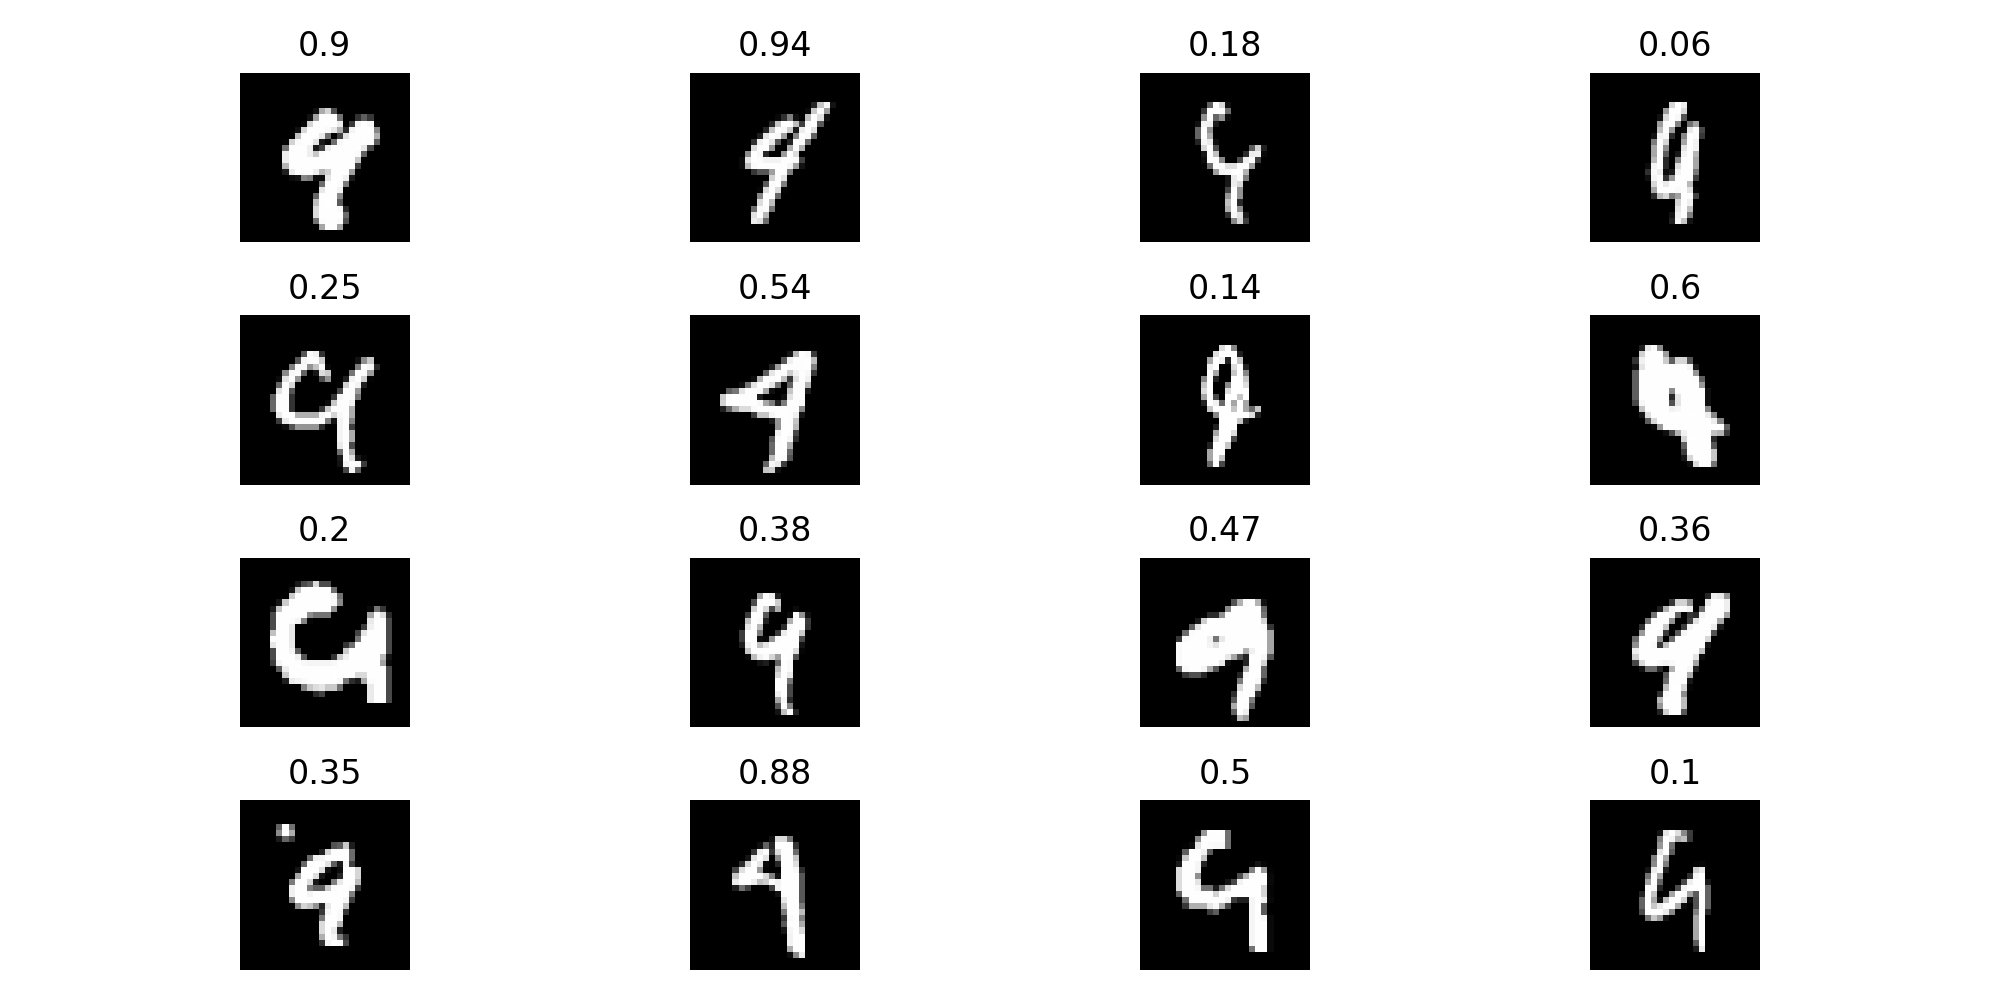

In [304]:
nerrors = len(errors)
print(nerrors)
rows = int(np.floor(np.sqrt(nerrors)))
cols = nerrors//rows
fig, ax = plt.subplots(rows, cols, figsize=(10, 5), tight_layout=True)
for i in range(rows):
    for j in range(cols):
        image = errors[i*rows+j].squeeze(0).squeeze(0).unsqueeze(2)
        conf = np.average(samples[i*rows+j])
        ax[i,j].imshow(image.numpy(), cmap=plt.cm.Greys_r)
        ax[i,j].axis('off')        
        ax[i,j].set_title(conf)